In [1]:
from typing import cast
import threading
import time
from textwrap import shorten
from dataclasses import dataclass
import itertools

import numpy as np
from datasets import Dataset, load_dataset, Audio # type: ignore
import gigaam
from gigaam.model import GigaAMASR
from tqdm.auto import tqdm
import IPython.display
import matplotlib.pyplot as plt

from asr_eval.streaming.sender import BaseStreamingAudioSender, StreamingAudioSender
from asr_eval.datasets.recording import Recording
from asr_eval.align.timings import CannotFillTimings
from asr_eval.streaming.evaluation import prepare_audio_format
from asr_eval.streaming.models.vosk import VoskStreaming
from asr_eval.utils.misc import new_uid
from asr_eval.streaming.buffer import ID_TYPE
from asr_eval.streaming.model import InputBuffer, OutputChunk, Signal, InputChunk, TranscriptionChunk

In [2]:
dataset = cast(
    Dataset, # type: ignore
    load_dataset('bond005/sberdevices_golos_100h_farfield')['test'].take(100) # type: ignore
    # load_dataset('bond005/podlodka_speech')['test'] #.take(100) # type: ignore
    .cast_column('audio', Audio(sampling_rate=16_000)) # type: ignore
)

In [3]:
gigaam_model = cast(GigaAMASR, gigaam.load_model('ctc', device='cuda'))

/home/oleg/asr-eval/venv/lib/python3.12/site-packages/gigaam/__init__.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=

In [4]:
recordings: list[Recording] = []
for sample in tqdm(dataset): # type: ignore
    try:
        recordings.append(Recording.from_sample(sample, use_gigaam=gigaam_model)) # type: ignore
    except CannotFillTimings:
        continue

len(recordings)

  0%|          | 0/100 [00:00<?, ?it/s]

100

In [7]:
asr = VoskStreaming(model_name='vosk-model-ru-0.42', chunk_length_sec=0.1)

LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=13 max-active=7000 lattice-beam=6
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 1 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 2 orphan components.
LOG (VoskAPI:Collapse():nnet-utils.cc:1488) Added 1 components, removed 2
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from /home/oleg/.cache/vosk/vosk-model-ru-0.42/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:279) Loading HCLG from /home/oleg/.cache/vosk/vosk-model-ru-0.42/graph/HCLG.fst
LOG (VoskAPI:ReadDataFiles():model.cc:297) Loading words from /home/oleg/.cache/vosk/vosk-model-ru-0.42/graph/words.txt
LOG (VoskAPI:ReadDataFiles():model.cc:30

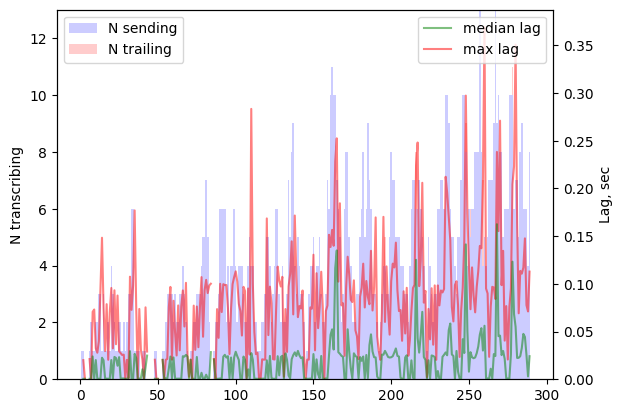

transcribing now:    4    sending now:    4    out.chunks/sec:    97    mean delay:    0.1    median delay:    0.0    max delay:    0.3
transcribing now:    2    sending now:    2    out.chunks/sec:    44    mean delay:    0.0    median delay:    0.0    max delay:    0.1
transcribing now:    6    sending now:    6    out.chunks/sec:    48    mean delay:    0.0    median delay:    0.0    max delay:    0.1
transcribing now:    4    sending now:    4    out.chunks/sec:    42    mean delay:    0.0    median delay:    0.0    max delay:    0.0
transcribing now:    5    sending now:    5    out.chunks/sec:    43    mean delay:    0.0    median delay:    0.0    max delay:    0.1
transcribing now:    8    sending now:    8    out.chunks/sec:    56    mean delay:    0.0    median delay:    0.0    max delay:    0.1
transcribing now:   13    sending now:   13    out.chunks/sec:   101    mean delay:    0.0    median delay:    0.0    max delay:    0.1
transcribing now:   11    sending now:   10    o

In [8]:
audio_lengths = [
    cast(float, len(sample['audio']['array']) / sample['audio']['sampling_rate']) # type: ignore
    for sample in dataset # type: ignore
]
avg_audio_len = np.mean(audio_lengths)
print(f'{avg_audio_len = :.2f} (min {min(audio_lengths):.2f}, max {max(audio_lengths):.2f})')

TICK_SIZE = 0.1
N_TICKS = 10000
START_N_THREADS = 1
FINISH_N_THREADS = 20

N_SENDS_PER_TICK_PER_THREAD = TICK_SIZE / avg_audio_len

expected_n_threads_for_each_tick = np.linspace(START_N_THREADS, FINISH_N_THREADS, num=N_TICKS)
expected_n_sends_for_each_tick = expected_n_threads_for_each_tick * N_SENDS_PER_TICK_PER_THREAD

seed = None
rng = np.random.default_rng(seed)
n_sends_for_each_tick = rng.poisson(expected_n_sends_for_each_tick)

# plt.plot(expected_n_sends_for_each_tick)
# plt.plot(np.convolve(n_sends_for_each_tick, np.ones(100) / 100))

senders_and_delays: dict[ID_TYPE, tuple[BaseStreamingAudioSender, float]] = {}

for tick_idx, n_sends in enumerate(n_sends_for_each_tick):
    start_time = tick_idx * TICK_SIZE
    
    for _ in range(n_sends):
        recording = cast(Recording, rng.choice(recordings)) # type: ignore
        assert recording.waveform is not None
        
        audio, array_len_per_sec = prepare_audio_format(recording.waveform, asr)
        sender = StreamingAudioSender(
            audio=audio,
            id=new_uid(),
            array_len_per_sec=array_len_per_sec,
            real_time_interval_sec=1 / 5,
            speed_multiplier=1,
        )
        senders_and_delays[sender.id] = (sender, start_time)

print(f'{len(senders_and_delays) = }')

asr.start_thread()

current_sending_ids: set[ID_TYPE] = set()
current_transcribing_ids: set[ID_TYPE] = set()
current_transcribing_ids_lock = threading.Lock()

def sender_wrapper_fn(sender: BaseStreamingAudioSender, send_to: InputBuffer):
    with current_transcribing_ids_lock:
        # print('start sending', sender.id)
        current_transcribing_ids.add(sender.id)
        current_sending_ids.add(sender.id)
        # print('current_sending_ids', current_sending_ids, flush=True)
    sender.start_sending(send_to)
    sender.join()
    with current_transcribing_ids_lock:
        current_sending_ids.remove(sender.id)

sender_timers: list[threading.Timer] = [
    threading.Timer(delay, sender_wrapper_fn, args=(sender, asr.input_buffer))
    for sender, delay in senders_and_delays.values()
]

outputs_finished: dict[ID_TYPE, list[OutputChunk]] = {}
outputs_not_finished: dict[ID_TYPE, list[OutputChunk]] = {
    sender.id: [] for sender, _ in senders_and_delays.values()
}
outputs_sequence: list[tuple[InputChunk, OutputChunk]] = []
outputs_lock = threading.Lock()

def find_input_chunk(id: ID_TYPE, output_chunk: OutputChunk) -> InputChunk:
    sender, _ = senders_and_delays[id]
    with sender.history_lock:
        for input_chunk in sender.history:
            if input_chunk.end_time >= output_chunk.seconds_processed:
                return input_chunk
        raise AssertionError('not found')

def receiver_thread_fn():
    while True:
        with outputs_lock:
            if len(outputs_not_finished) == 0:
                print('receiver thread finished')
                return
        try:
            output_chunk, id = asr.output_buffer.get()
            # print(f'received chunk for {id}')
        except RuntimeError as e:
            print(f'receiver thread interrupted: {e}')
            return
        
        with outputs_lock:
            assert id in current_transcribing_ids, f'cannot find id {id}'
            assert id in outputs_not_finished, f'received output chunk for unknown id {id}'
            outputs_not_finished[id].append(output_chunk)
            
            outputs_sequence.append((find_input_chunk(id, output_chunk), output_chunk))
            
            if output_chunk.data is Signal.FINISH:
                with current_transcribing_ids_lock:
                    current_transcribing_ids.remove(id)
                outputs_finished[id] = outputs_not_finished[id]
                del outputs_not_finished[id]
                # text = TranscriptionChunk.join(outputs_finished[id])
                # print(f'Transcribed {id}: {shorten(text, width=80)}', flush=True)
    

@dataclass
class LoadStats:
    n_transcribing: int
    n_sending: int
    delays_for_last_sec: list[float]
    
    def report(self) -> str:
        delays = self.delays_for_last_sec
        return (
            f'transcribing now: {self.n_transcribing:4d}'
            f'    sending now: {self.n_sending:4d}'
            f'    out.chunks/sec: {len(delays):5d}'
            f'    mean delay: {np.mean(delays) if len(delays) else np.nan:6.1f}'
            f'    median delay: {np.median(delays) if len(delays) else np.nan:6.1f}'
            f'    max delay: {np.max(delays) if len(delays) else np.nan:6.1f}'
        )
   
stats_history: list[LoadStats] = []  # access only from watcher_thread_fn

def stop_testing():
    for timer in sender_timers:
        timer.cancel()
    asr.stop_thread()

def display_stats_history(stats_history: list[LoadStats]):
    ax1, ax2 = plt.gca(), plt.gca().twinx()
    
    ax2.plot([ # type: ignore
        np.median(stats.delays_for_last_sec) if len(stats.delays_for_last_sec) else np.nan
        for stats in stats_history
    ], label='median lag', alpha=0.5, color='g', zorder=2)
    ax2.plot([ # type: ignore
        np.max(stats.delays_for_last_sec) if len(stats.delays_for_last_sec) else np.nan
        for stats in stats_history
    ], label='max lag', alpha=0.5, color='r', zorder=1)
    ax2.legend() # type: ignore
    
    ax1.bar( # type: ignore
        x=range(len(stats_history)),
        height=[stats.n_sending for stats in stats_history],
        width=1,
        color='blue',
        label='N sending',
        zorder=-10,
        alpha=0.2,
    )
    ax1.bar( # type: ignore
        x=range(len(stats_history)),
        height=[stats.n_transcribing - stats.n_sending for stats in stats_history],
        bottom=[stats.n_sending for stats in stats_history],
        width=1,
        color='red',
        label='N trailing',
        zorder=-10,
        alpha=0.2,
    )
    
    ax1.legend(loc=0) # type: ignore
    ax2.legend(loc=1) # type: ignore
    
    ax1.set_ylim(0, None)
    ax2.set_ylim(0, None)
    
    plt.xlabel('Test duration, sec') # type: ignore
    ax1.set_ylabel('N transcribing') # type: ignore
    ax2.set_ylabel('Lag, sec') # type: ignore
    
    plt.show() # type: ignore

def watcher_thread_fn():  # todo use async - await?
    processed_sequence_size = 0
    for sec_idx in itertools.count():
        time.sleep(1)
        with current_transcribing_ids_lock:
            if len(outputs_not_finished) == 0:
                break
            n_transcribing = len(current_transcribing_ids)
            n_sending = len(current_sending_ids)
        with outputs_lock:
            new_data = outputs_sequence[processed_sequence_size:]
            processed_sequence_size = len(outputs_sequence)
            delays = [
                output_chunk.put_timestamp - input_chunk.put_timestamp
                for input_chunk, output_chunk in new_data
            ]
        stats = LoadStats(
            n_transcribing=n_transcribing,
            n_sending=n_sending,
            delays_for_last_sec=delays
        )
        stats_history.append(stats)
        print(stats.report())
        
        if np.mean(stats.delays_for_last_sec) > 50:
            print('stopping testing')
            stop_testing()
            display_stats_history(stats_history)
            return
        
        if sec_idx % 10 == 9:
            IPython.display.clear_output()
            display_stats_history(stats_history)
            
    print('watcher done')
    

for timer in sender_timers:
    timer.start()
    
receiver_thread = threading.Thread(target=receiver_thread_fn)
receiver_thread.start()    

watcher_thread = threading.Thread(target=watcher_thread_fn)
watcher_thread.start()

try:
    receiver_thread.join()
    watcher_thread.join()
except KeyboardInterrupt:
    with outputs_lock:
        outputs_not_finished = {}  # to stop watcher
asr.stop_thread()